<a href="https://colab.research.google.com/github/sfatimazahra/ML-Image-Classification-using-CIFAR-100/blob/main/DenseNet_(Transfer_Learning_%2B_Scratch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report

from keras.optimizers import Adam
from keras.models import Sequential
from keras.datasets import cifar100
from keras.utils import to_categorical
from keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, Dropout, Flatten

## **Loading and Preprocessing**

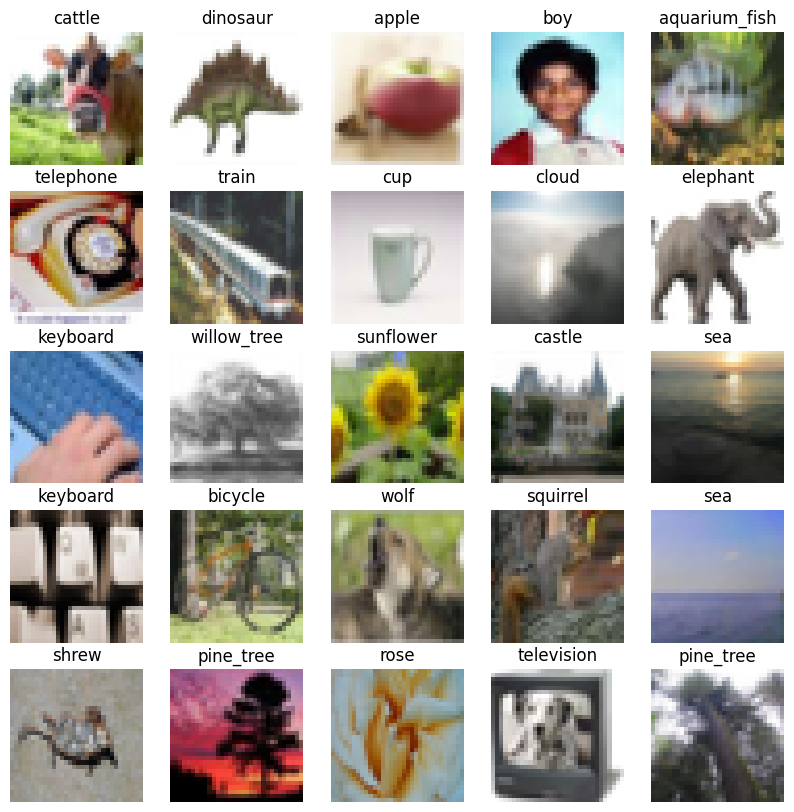

(50000, 32, 32, 3)


In [98]:
# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Map class indices to class names
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup',
    'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house',
    'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man',
    'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid',
    'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew',
    'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower',
    'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis('off')

plt.show()
print(x_train.shape)

In [99]:
# Normalize the entire dataset
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_val = x_val.astype('float32') / 255

# Convert labels to one-hot encoded vectors
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)
y_val = to_categorical(y_val, 100)

## **DENSE NET 121 LAYER MODEL (Transfer Learning)**

In [52]:
# Define the DenseNet model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='softmax')
])

model.compile(optimizer= Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6) #Reduces learning rate when no improvment in validation loss
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True) #Stops when we see no improvement

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1, 1, 1024)        7037504   
                                                                 
 flatten_9 (Flatten)         (None, 1024)              0         
                                                                 
 dense_28 (Dense)            (None, 512)               524800    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_29 (Dense)            (None, 100)               51300     
                                                                 
Total params: 7613604 (29.04 MB)
Trainable params: 7529956 (28.72 MB)
Non-trainable params: 83648 (326.75 KB)
_________________________________________________________________


Data Augmentation

In [54]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the ImageDataGenerator on the training data
datagen.fit(x_train)

In [55]:
epochs = 60
batch_size = 128

history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) // batch_size,
                    epochs=epochs,
                    validation_data=(x_val, y_val),
                    callbacks=[lr_scheduler, early_stopping]
                    )

test_loss, test_accuracy = model.evaluate(x_test, y_test)


Epoch 1/60
390/390 [==============================] - 120s 156ms/step - loss: 3.6735 - accuracy: 0.1427 - val_loss: 4.9051 - val_accuracy: 0.1594 - lr: 0.0010
Epoch 2/60
390/390 [==============================] - 61s 157ms/step - loss: 2.7676 - accuracy: 0.2923 - val_loss: 3.2810 - val_accuracy: 0.2698 - lr: 0.0010
Epoch 3/60
390/390 [==============================] - 61s 157ms/step - loss: 2.6452 - accuracy: 0.3277 - val_loss: 3.4074 - val_accuracy: 0.2276 - lr: 0.0010
Epoch 4/60
390/390 [==============================] - 59s 152ms/step - loss: 2.4735 - accuracy: 0.3650 - val_loss: 2.7585 - val_accuracy: 0.3296 - lr: 0.0010
Epoch 5/60
390/390 [==============================] - 60s 153ms/step - loss: 2.4075 - accuracy: 0.3770 - val_loss: 3.0493 - val_accuracy: 0.3680 - lr: 0.0010
Epoch 6/60
390/390 [==============================] - 59s 152ms/step - loss: 2.3434 - accuracy: 0.3909 - val_loss: 4.7869 - val_accuracy: 0.3248 - lr: 0.0010
Epoch 7/60
390/390 [==============================]

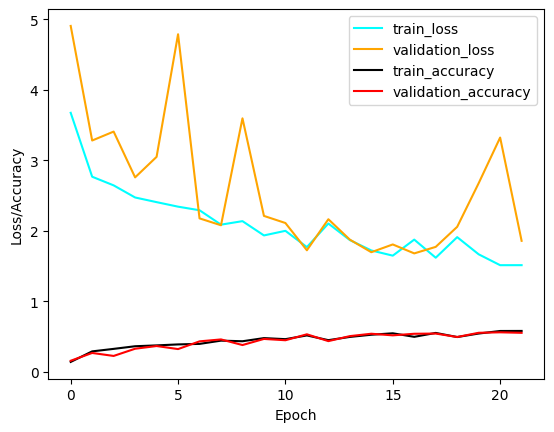

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test Accuracy: 0.5311999917030334
Test Loss: 1.7438308000564575


In [56]:
plt.plot(history.history['loss'], label='train_loss', color = 'Cyan')
plt.plot(history.history['val_loss'], label='validation_loss', color = 'Orange')
plt.plot(history.history['accuracy'], label='train_accuracy', color = 'black')
plt.plot(history.history['val_accuracy'], label='validation_accuracy', color = 'red')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.show()

# model_save_path = 'E:\\University\\FYP Stuff\\Models For SkinTone Recognition\\Skintone_Recognition_3.h5'
model_save_path = 'C:\\NUST\\7th Semester\\Computer Vision\\CV proj\\skintone_recog1.h5'
model.save(model_save_path)

print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

# **15 Layer Dense Model (SCRATCH)**

In [101]:
model = Sequential()

# Convolutional layers with batch normalization and max pooling
model.add(Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu',padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu',padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu',padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu',padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu',padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))

# Output layer
model.add(Dense(100, activation='softmax'))

model.compile(optimizer= Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6) #Reduces learning rate when no improvment in validation loss
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True) #Stops when we see no improvement

model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_74 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_74 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_75 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_75 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                     

Data Augmentation

In [102]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the ImageDataGenerator on the training data
datagen.fit(x_train)

print(x_train.shape)

(50000, 32, 32, 3)


In [103]:
epochs = 60
batch_size = 128

history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) // batch_size,
                    epochs=epochs,
                    validation_data=(x_val, y_val),
                    callbacks=[lr_scheduler, early_stopping]
                    )

test_loss, test_accuracy = model.evaluate(x_test, y_test)

Epoch 1/60
390/390 [==============================] - 44s 97ms/step - loss: 4.3135 - accuracy: 0.0443 - val_loss: 4.3431 - val_accuracy: 0.0332 - lr: 0.0010
Epoch 2/60
390/390 [==============================] - 36s 92ms/step - loss: 3.8786 - accuracy: 0.0884 - val_loss: 3.8957 - val_accuracy: 0.1006 - lr: 0.0010
Epoch 3/60
390/390 [==============================] - 37s 95ms/step - loss: 3.6571 - accuracy: 0.1197 - val_loss: 3.4174 - val_accuracy: 0.1734 - lr: 0.0010
Epoch 4/60
390/390 [==============================] - 38s 96ms/step - loss: 3.4376 - accuracy: 0.1543 - val_loss: 3.2427 - val_accuracy: 0.1982 - lr: 0.0010
Epoch 5/60
390/390 [==============================] - 36s 93ms/step - loss: 3.2253 - accuracy: 0.1964 - val_loss: 3.0944 - val_accuracy: 0.2280 - lr: 0.0010
Epoch 6/60
390/390 [==============================] - 38s 97ms/step - loss: 3.0259 - accuracy: 0.2336 - val_loss: 2.7208 - val_accuracy: 0.2948 - lr: 0.0010
Epoch 7/60
390/390 [==============================] - 37s 

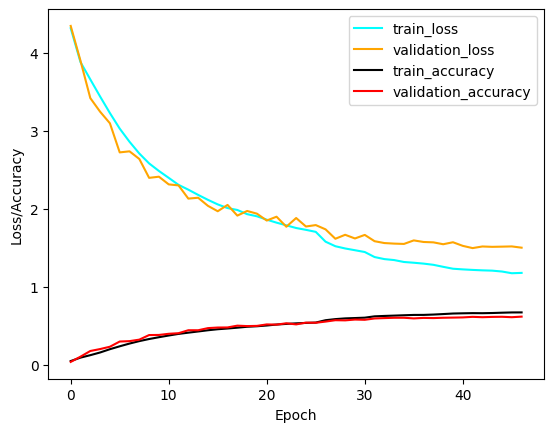

Test Accuracy: 0.5892000198364258
Test Loss: 1.6157550811767578


In [104]:
plt.plot(history.history['loss'], label='train_loss', color = 'Cyan')
plt.plot(history.history['val_loss'], label='validation_loss', color = 'Orange')
plt.plot(history.history['accuracy'], label='train_accuracy', color = 'black')
plt.plot(history.history['val_accuracy'], label='validation_accuracy', color = 'red')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.show()

print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")